# Cab Orders Forecast

The goal of any business is to make a profit.
Depending on the type of enterprise, various factors can influence profits, including the correct allocation of resources, as well as the modulation of supply depending on demand. Taxi services are no exception.

A taxi company has collected historical data on taxi orders at airports. In order to attract more drivers during the peak period, and, accordingly, increase profits, we need to predict the number of taxi orders for the next hour.
Our task is to build a model for predicting the number of orders, which will produce the highest quality forecast at the output.
To build the model, we have at our disposal historical data on dates / times and the number of taxi orders stored in the following csv file: '/datasets/taxi.csv.

We know from the assignment that the number of orders is in the 'num_orders' column.


**The purpose of this study** is to prepare a prototype of a machine learning model for the taxi service, taking into account the fact that the quality of prediction is important for the customer. To assess the quality of the model, we will use the standard metric **RMSE, that is, the square root of the mean squared error, which should not exceed 48**.

**Research progress**:

We will try to build both traditional regression and gradient boosting models by fitting the best hyperparameters, train them and select the best hyperparameters through cross-validation, and then evaluate as RMSE on the test sample.


Thus, this project will include the following steps:
* data preprocessing and analysis
* building models and fitting them
* assessment of the quality of the model

## Data Preprocessing



In [1]:
import numpy as np  # importing numpy
import pandas as pd  # importing pandas
import os.path as path # importing os.path for path handling
from sklearn.linear_model import LinearRegression # importing linear regression
import warnings # importing warnings 
warnings.simplefilter("ignore")
from sklearn.metrics  import  make_scorer # importing for customizing score
from sklearn.ensemble import RandomForestRegressor # importing random forest
from sklearn.dummy import DummyRegressor # importing DummyRegressor for baseline model
from catboost import CatBoostRegressor # importing Catboost
from lightgbm import LGBMRegressor # importing LGBM
from sklearn.model_selection import train_test_split  # importing the function for splitting dataset
from sklearn.metrics import mean_squared_error # importing MSE
from sklearn.model_selection import  RandomizedSearchCV # importing RandomSearchCV to search for the best hyperparameters
from statsmodels.tsa.seasonal import seasonal_decompose # importing the function to analyze trends and seasons
from sklearn.model_selection import TimeSeriesSplit # importing thr class for splitting Time Series

### Data Overview and Basic Data Analysis
Let's make the first idea about the data. To view and analyze, we will read the file in csv format, save them to a variable, and also look at the first 10 lines.

In [2]:
# reading the csv file and saving to df
try:
    base_path = 'taxi.csv' 
    df = pd.read_csv(base_path, index_col=[0], parse_dates=[0]) if path.exists(base_path) else pd.read_csv(f'/datasets/{base_path}', index_col=[0], parse_dates=[0]) # checking the path
    display(df.head(10))  # getting the first 10 rows
except:
     print('File not found') # if no path is correct, an error message will be printed


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Next, we will get general information about the dataset and check the quality of the data. 

In [3]:
df.info() # getting general information on the df


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


So, from the first overview of the dataset, we can conclude that it contains 1 feature - the number of taxi orders, which will also be the target for us. This feature is quantitative, hence the data type is as expected. The index contains the date and time with an interval of 10 minutes.
 

Since there is only one feature, and there is a possibility that the number of orders for the selected interval is repeated, it makes no sense to check the dataframe for full duplicates. In any case, even if we didn't use 'datatime' as an index, there would still be no full duplicates. Since some regression models are sensitive to missing values,  let's check the df for them:

In [4]:
df.isna().mean() # checking the df for NaNs

num_orders    0.0
dtype: float64

So, there are no missing values in our dataframe, then we will analyze the range of indexes, which are the date and time, as well as the distribution of the feature.


In [5]:
df.index.is_monotonic # checking if the index order is proper

True

So, the order in the index is observed, there is no need to sort it. Next, let's see what range of dates and times our dataframe covers:


In [6]:
df.index.min() # displaying the min index

Timestamp('2018-03-01 00:00:00')

In [7]:
df.index.max() # displaying the max index

Timestamp('2018-08-31 23:50:00')

The minimum and maximum index tell us that the data covers several months of only one year, namely the period from zero am on March 1 to 11 pm on August 31, 2018. We will need this data later when creating features.

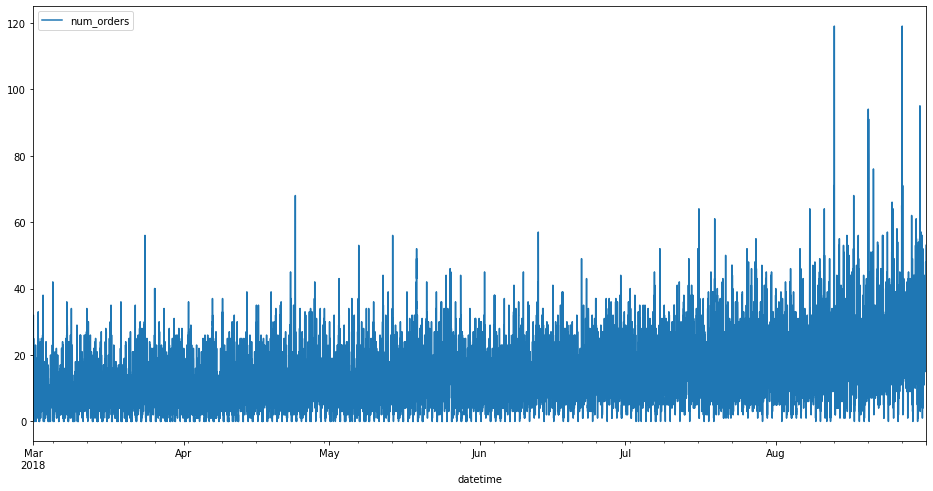

In [8]:
df.plot(figsize=(16,8)); # plotting the orders' number distribution

The distribution from March to June resembles a stationary series, but further, in the last two months of observations, the number of orders is clearly growing (summer is a vacation period, more people travel), respectively, their arithmetic mean also increases.

Further, in accordance with the task, we should resample the feature for one hour, calculate the total number of orders in each group, and then look again at its distribution:

In [9]:
df = df.resample('1H').sum()# resampling the df

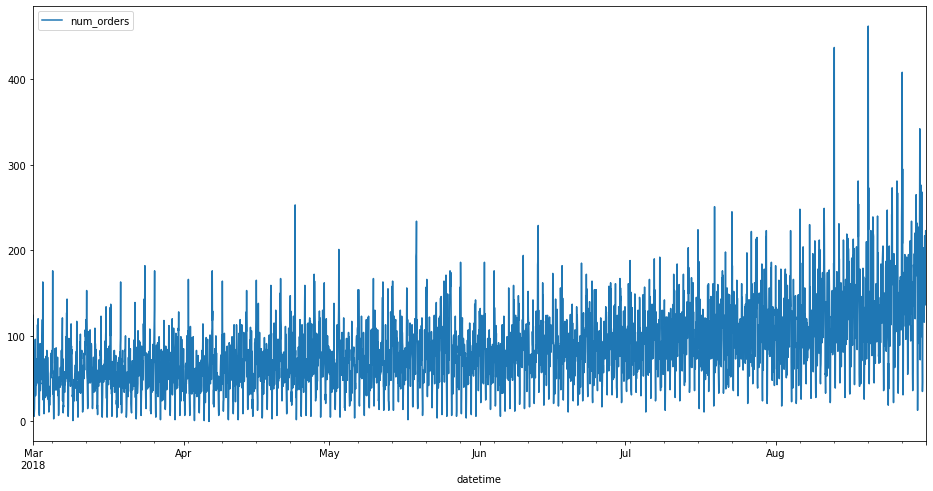

In [10]:
df.plot(figsize=(16,8)); # plotiing the distribution after resampling

A certain, not very strong, enlargement of the feature is noticeable, the same trend is visible in the distribution.

Next, let's analyze our time series for trends. Since we know that the data are presented only for a few months of one year, it is not possible to analyze them for seasonality.

In [11]:
decomposed = seasonal_decompose(df) # splitting the data

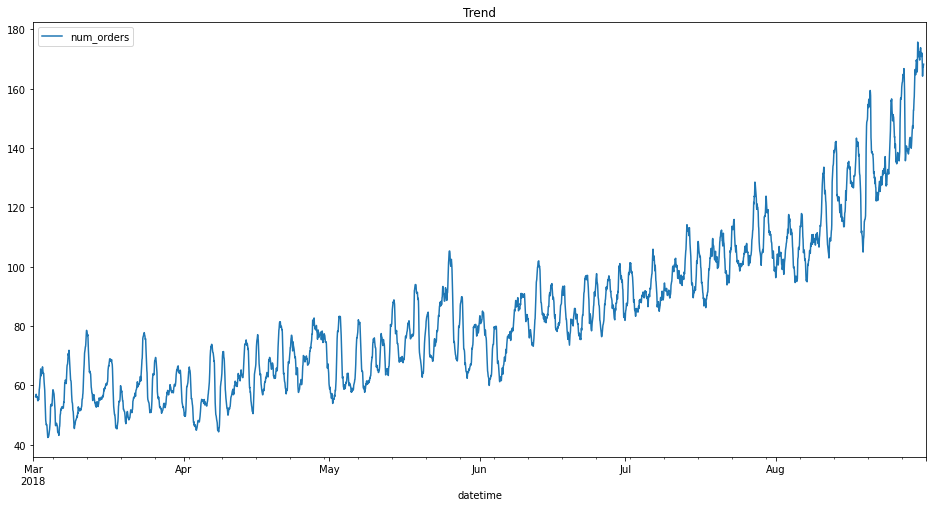

In [12]:
decomposed.trend.plot(title='Trend', figsize=(16,8)); # plotting the trend

So, based on the plot, we see a trend towards an increase in taxi orders as we move from spring to summer. You can notice a certain surge in mid-May (perhaps this is due to the May holidays or the combination of holidays and additional vacation days), then, in the first half of June, a certain drop in demand (if you flew away on vacation in May, they are unlikely to fly again in 2 weeks), and then, from mid-June, a steady upward trend in demand: as we mentioned above, this is most likely due to the holiday period.


**Conclusions**

So, we did a overview and basic analysis of the data: the quality of the data was satisfactory, we did not have to deal with duplicates or NaNs, we also analyzed the range of the index and the distribution of the feature, revealing an upward trend in the summer months. Next, let's move on to the special preparation of the dataset necessary for building the model.


### Preparing Data for Modelling
The task of time series forecast is to build a model that, based on historical data, will predict the future values of the time series. In our case, we should predict the number of orders for the next hour, that is, the forecasting horizon in our case is an hour, and we are faced with the regression task.

To fit models, we first need to create features. To do this, we are about to define a standard function,
which will return dataframe wit the new features:
 - calendar features to identify the trend and seasonality, which we will extract from the index. Taking into account the forecasting horizon and the fact that the data is only for 2018, we should add the following calendar features: day of the week, hour of the day.
 - the so-called "lagging values", which will tell us whether the value function of the time series x(t) will increase or decrease.
 - rolling mean, which will reduce fluctuations and set the general trend of the time series, not including the current value of the series.

In [13]:
# defining a function which return a new df with features 
def make_features(data, max_lag, rolling_mean_size):
    feature_data = data.copy()
    feature_data['dayofweek'] = feature_data.index.dayofweek
    feature_data['hour'] = feature_data.index.hour
    
    for lag in range(1, max_lag + 1):
        feature_data['lag_{}'.format(lag)] = feature_data['num_orders'].shift(lag)

    feature_data['rolling_mean'] = feature_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return feature_data

Let's apply the function to our dataset. Let's try 1 as lagging value because it makes sense to think that the orders of the previous hour influence the orders of the current hour and 24 as the rolling value, in order to smooth order fluctations for a day (24 hours).

In [14]:
feature_data = make_features(df, 1, 24) # creating a new df with features
feature_data.head() # checking the result


,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN


Next, we shall divide the dataframe into training and test samples. In accordance with the task, the size of the test sample should be 10% of the original data. We cannot mix samples in a time series forecasting. The training sample data must precede the test sample data, otherwise testing the model will be incorrect: the model should not be trained on data from the future. To avoid data shuffling, set the shuffle argument to False:

In [15]:
train, test = train_test_split(feature_data, shuffle=False, test_size=0.1) # splitting the data into trai and test samples

Let's check is the split has occured properly:

In [16]:
print(len(test), len(train), len(train)+len(test)==len(df), sep='\n') # checking if the split was correct

442
3974
True


In [17]:
print(train.index.max(), test.index.min(), sep='\n') # checking if the split was correct

2018-08-13 13:00:00
2018-08-13 14:00:00


According to the task, we need to test several regression models, including traditional ones. We know that they do not handle missing values, and the NaNs after the features creation appeared. Let's create a separate sample for traditional models by removing missing values. Taking into account the specifics of the breakdown of the dataset, there are missing values only in the training sample:

In [18]:
train_trad = train.dropna() # dropping missing values
train_trad.head() #  checking the result

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-02 00:00:00,90,4,0,58.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,56.958333


Let's separate the target in each sample:

In [19]:
# separating the target  from the features
target_train = train['num_orders']
features_train = train.drop(columns=['num_orders'])
target_train_trad = train_trad['num_orders']
features_train_trad = train_trad.drop(columns=['num_orders'])
target_test = test['num_orders']
features_test = test.drop(columns=['num_orders'])


**Conclusions:**

So, we have carried out a special preprocessing of the dataframe, which will allow us to build, fit models and get predictions. It's time to move on to choosing the best of them by searching for optimal hyperparameters.

## Models

### Traditional Models

So our goal is to predict the number of orders for the next hour and adjust the number of available taxis accordingly. There can be many answers to this question, these will be specific numbers, so our target feature is quantitative, and we are solving a regression problem.
To solve this problem, we will test 2 traditional models: random forest and linear regression. We will check the quality of training by cross-validation, estimating the square root of the mean squared error (RMSE). According to the assignment, this metric should not exceed the value of 48.
The results will be presented in a pivot table.

In [20]:
models = ['linear regression', 'random forest', 'catboost', 'lgbm'] # creating a list of models
rmse = [] # creating an empty list for rmse resultys


Let's start with the linear regression but first we shall define a function to calculate the selected quality metrics:

In [21]:
# defining a function to calculate RMSE
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [22]:
model = LinearRegression()  # creating a model
param_distributions = {'fit_intercept': [True, False], 'normalize': [True, False]}  #  setting the parameters
tscv = TimeSeriesSplit(n_splits=8) # setting the number of folds for time series cross validation
grid_linear_r = RandomizedSearchCV(model, param_distributions, scoring = RMSE_score, cv=tscv, n_jobs=-1) # creating a  RandomSearchCV
grid_linear_r.fit(features_train_trad, target_train_trad) #  fitting the model
print('RSME of the best linear regression is', (grid_linear_r.best_score_), 'with the following hyperparameters', grid_linear_r.best_params_) # displaying the best result



RSME of the best linear regression is -31.324746747745746 with the following hyperparameters {'normalize': True, 'fit_intercept': False}


Thus, we have found the best linear regression hyperparameters on the training set. Now let's check the quality of the predictions on the test set.

In [23]:
model =  LinearRegression(normalize=True, fit_intercept=False)  # creating a model
model.fit(features_train_trad, target_train_trad) # fitting the model
predictions = model.predict(features_test) # predicting the target
rmse_linear_regression = RMSE(target_test, predictions) # calculating RMSE
rmse.append(rmse_linear_regression) # appending rmse to the list
rmse_linear_regression

51.10828356992224

Both fitting and predicting of the  linear regression are quite fast. The result of the prediction quality on the training sample is very high, but on the test sample it is much lower (apparently, the model has been retrained) and, in any case, the square root of the mean squared error is too high - it exceeds the set threshold of 48. Therefore, this model does not fit us.

Next, we will try  a traditionally fairly accurate but slow random forest model:

In [24]:
model = RandomForestRegressor(random_state=12345) #  creating a model
tscv = TimeSeriesSplit(n_splits=8) # setting the number of folds for time series cross validation
param_distributions = {'n_estimators': range (10, 110, 10), 'max_depth': range (1,11)}   #  setting the parameters
grid_forest_r = RandomizedSearchCV(model, param_distributions, scoring=RMSE_score, cv=tscv, n_jobs=-1) # creating a  RandomSearchCV
grid_forest_r.fit(features_train_trad, target_train_trad) #  fitting the model
print('RSME of the best random forest is', grid_forest_r.best_score_, 'with the following hyperparameters', grid_forest_r.best_params_ ) # displaying the best result


RSME of the best random forest is -24.878786885681663 with the following hyperparameters {'n_estimators': 70, 'max_depth': 10}


The optimal random forest parameters for our data have been found. Now let's test its quality on test data:

In [25]:
model =  RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=9)  # creating a model
model.fit(features_train_trad, target_train_trad) # fitting the model
predictions = model.predict(features_test) # predicting the target
rmse_random_forest = RMSE(target_test, predictions) # calculating RMSE
rmse.append(rmse_random_forest) # appending rmse to the list
rmse_random_forest

47.58075821423484

So, in this case, the model learned and predicted the target feature fairly quickly. As in the previous case, the quality metric of random forest predictions on the training sample is much higher than on the test sample, however, the resulting value already satisfies the threshold set in the task.

### Gradient Boosting

Next, we will test the gradient boosting models. We know that they themselves are able to handle NaNs, so we will train them on a sample containing NaNs. Let's start with CatBoost:

In [26]:
model = CatBoostRegressor(random_seed=12345) #  creating a model
tscv = TimeSeriesSplit(n_splits=8) # setting the number of folds for time series cross validation
param_distributions = {'iterations': range (10, 110, 10), 'max_depth': range (1,11), 'learning_rate': [0.1, 0.2, 0.3]}   #  setting the parameters
clf_b = RandomizedSearchCV(model, param_distributions, scoring=RMSE_score, cv=tscv, n_jobs=-1) # creating a  RandomSearchCV
clf_b.fit(features_train, target_train,  verbose=10) # fitting the model
print('RSME of the best Catboost is', clf_b.best_score_, 'with the following hyperparameters', clf_b.best_params_ ) # displaying the best result


0:	learn: 36.8218796	total: 128ms	remaining: 11.4s
10:	learn: 26.8219519	total: 210ms	remaining: 1.51s
20:	learn: 23.8449070	total: 287ms	remaining: 943ms
30:	learn: 22.6263296	total: 365ms	remaining: 694ms
40:	learn: 21.8954860	total: 440ms	remaining: 526ms
50:	learn: 21.1119413	total: 513ms	remaining: 393ms
60:	learn: 20.5648969	total: 577ms	remaining: 274ms
70:	learn: 20.1690804	total: 661ms	remaining: 177ms
80:	learn: 19.7214588	total: 770ms	remaining: 85.5ms
89:	learn: 19.3174010	total: 855ms	remaining: 0us
RSME of the best Catboost is -24.49762522976986 with the following hyperparameters {'max_depth': 9, 'learning_rate': 0.1, 'iterations': 90}


In [27]:
model =  CatBoostRegressor(random_seed=12345, max_depth=6, learning_rate=0.3, iterations=60)  # creating a model
model.fit(features_train, target_train,  verbose=10) # fitting the model
predictions = model.predict(features_test) # predicting the target
rmse_catboost = RMSE(target_test, predictions) # calculating RMSE
rmse.append(rmse_catboost) # appending rmse to the list
rmse_catboost

0:	learn: 33.6911232	total: 7.77ms	remaining: 458ms
10:	learn: 23.9785638	total: 34.2ms	remaining: 152ms
20:	learn: 22.1312639	total: 54.3ms	remaining: 101ms
30:	learn: 21.1185669	total: 69ms	remaining: 64.6ms
40:	learn: 20.3257513	total: 87.4ms	remaining: 40.5ms
50:	learn: 19.6199876	total: 102ms	remaining: 18.1ms
59:	learn: 19.0943358	total: 132ms	remaining: 0us


45.15194748653677

The results of CatBoost show the same trend as in traditional machine learning models: on the training sample, the value of the square root of the mean squared error is almost two times less than on the test sample. However, this time the result is even less than 48, so this model suits us.
Next, let's test the last model in our list -LGBM:

In [28]:
model =  LGBMRegressor(random_seed=12345) # creating a model
tscv = TimeSeriesSplit(n_splits=8) # setting the number of folds for time series cross validation
param_distributions = {'n_estimators': range (10, 110, 10), 'num_leaves': [10,20,31], 'max_depth': range (1,11), 'learning_rate': [0.1, 0.2, 0.3]}   #  setting the parameters
clf_l = RandomizedSearchCV(model, param_distributions, scoring=RMSE_score, cv=tscv, n_jobs=-1) # creating a  RandomSearchCV
clf_l.fit(features_train, target_train) #  fitting the model
print('RSME of the best LGBM is', clf_l.best_score_, 'with the following parameters', clf_l.best_params_ ) # displaying the best result



RSME of the best LGBM is -24.580930924973586 with the following parameters {'num_leaves': 31, 'n_estimators': 30, 'max_depth': 8, 'learning_rate': 0.3}


In [29]:
model =  LGBMRegressor(random_seed=12345, num_leaves = 10, max_depth=5, learning_rate=0.3, n_estimators=60)  # creating a model
model.fit(features_train, target_train) # fitting the model
predictions = model.predict(features_test) # predicting the target
rmse_lgbm = RMSE(target_test, predictions) # calculating RMSE
rmse.append(rmse_lgbm) # appending rmse to the list
rmse_lgbm

43.64579374389063

So, in terms of fitting rate and quality of predictions on the training sample, the results of both gradient boosting models are comparable. However, LGBM showed a slightly better result than CatBoost, and the best among all models.

So, before making the final choice, we will compile a summary table for all models, and also compare the results of the leader with the baseline models.

In [30]:
Models = pd.DataFrame({'rmse': rmse}, index=models) # creating a summary df on all tested models
Models


,rmse
linear regression,51.108284
random forest,47.580758
catboost,45.151947
lgbm,43.645794


Let's use two strategies for building a baseline model and compare the results with the results of LGBM:
* all values of the test sample will be predicted by the same number (arithmetic mean);
* the new value of x(t) is predicted by the previous value of the series, i.e. x(t-1).

In [31]:
dummy_regr_r = DummyRegressor(strategy="mean") # сcreating a baseline model
dummy_regr_r.fit(features_train, target_train) # fitting it
dummy_predictions = dummy_regr_r.predict(features_test) # predicting the target

In [32]:
rmse_dummy = RMSE(target_test, dummy_predictions) # calculating RMSE
rmse_dummy

84.74414402014742

In [33]:
pred_previous = target_test.shift() # with the use of shift filling in each observation with the previous one
pred_previous.iloc[0] = target_train.iloc[len(target_train)-1] # filling in the first observation with the last one of the train sample

In [34]:
rmse_previous = RMSE(target_test, pred_previous) # calculating RMSE
rmse_previous

58.856486242815066

So, the baseline model showed different from all other models, and most importantly, the worst results.
Next, we will graphically display the predictions of the best model and the actual values of the target feature. Let's select values for only a few days, so that the plot is clear:

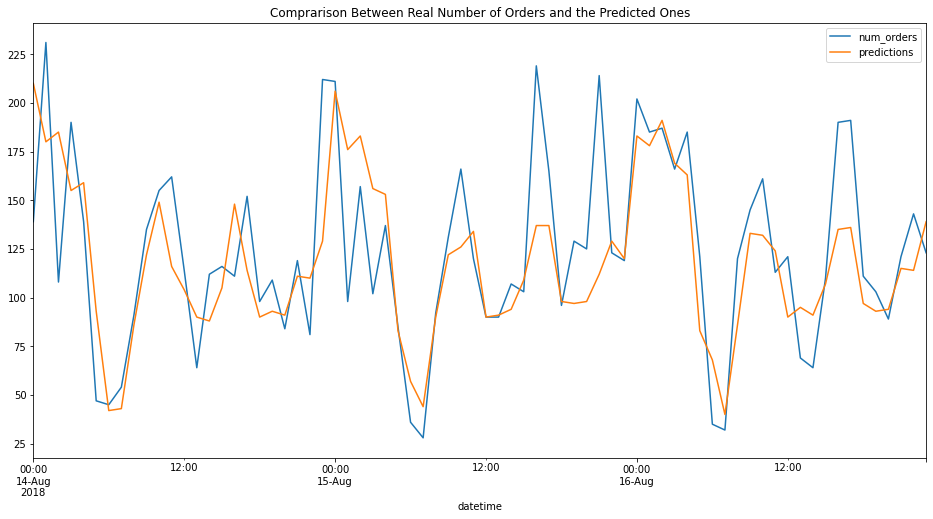

In [35]:
# plotting the real target values and the predicted ones
graph = target_test.copy()
predictions_taxi = pd.DataFrame(data = predictions, columns = ['predictions'], index = target_test.index.copy())
df_to_plot = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_to_plot['predictions'] = df_to_plot['predictions'].astype('int64')
df_to_plot['2018-08-14':'2018-08-16'].plot(figsize=(16,8), title='Comprarison Between Real Number of Orders and the Predicted Ones');


So, the prediction line appears to be smoother than the real values line: our model is not so good at predicting sharp declines and increases in the number of orders, but, nevertheless, follows the trend of real values.
Nevertheless, the selected model reaches the established quality threshold, it is adequate, therefore, it can go into production.

## Study Results
In the course of this study, we prepared and analyzed the data, added features for predicting time series, created 2 samples with and without missing valuesfor 2 groups of regression models, respectively.

We checked the results of model training by cross-validation, choosing the optimal hyperparameters.
According to the results of the comparison, it turned out that  ** the gradient boosting, namely, LGBM predicts most qualitatively  the number of orders for the next hour in our sample (with a minimum value of RMSE equal to about 43.6 - below the established threshold).**

Perhaps the result would be even better if we applied alternative regression models not yet known to us, and also if we passed different arguments to the feature creation function for time series prediction.